In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.LP import SpatialLocalPooling
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

In [4]:
adata=sc.read_h5ad('/home/dbj/SpaLA/Batch/CODEX/BALBc-3.h5ad')
adata.var_names_make_unique()
adata.obs['type']='Pre-training data'

In [5]:
sc.pp.scale(adata)
adata.obsm['feat']=adata.X

In [6]:
k=50
graph = prepare_inputs(adata, k, device)

In [7]:
in_channels = graph.features.shape[1]
model = SpatialLocalPooling(in_channels, out_channels=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 15.46it/s, Epoch=199, Loss=0.8294]


In [9]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

In [10]:
adata.obsm['SpaLP']=embedding

In [11]:
torch.save(model.state_dict(), "/home/dbj/SpaLP/gittest/SpaLP/general/CODEX/setting3/BALBc-3_pretrian_model.pth")

In [12]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/CODEX/setting3/Pre-training.h5ad',compression='gzip')

In [13]:
from SpaLP.utils import transfer_labels_by_cosine

In [14]:
adata1=sc.read_h5ad('/home/dbj/SpaLA/Batch/CODEX/BALBc-1.h5ad')
adata1.var_names_make_unique()
adata1.obs['type']='Inference data1'

adata2=sc.read_h5ad('/home/dbj/SpaLA/Batch/CODEX/BALBc-2.h5ad')
adata2.var_names_make_unique()
adata2.obs['type']='Inference data2'

In [15]:
sc.pp.scale(adata1)
adata1.obsm['feat']=adata1.X

sc.pp.scale(adata2)
adata2.obsm['feat']=adata2.X

In [16]:
graph1 = prepare_inputs(adata1, k=50, device=device)
graph2 = prepare_inputs(adata2, k=50, device=device)

In [17]:
in_channels = graph1.features.shape[1]
model = SpatialLocalPooling(in_channels, out_channels=32).to(device)
model.load_state_dict(torch.load("/home/dbj/SpaLP/gittest/SpaLP/general/CODEX/setting3/BALBc-3_pretrian_model.pth", map_location="cpu"))
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph1.features, graph1.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

adata1.obsm['SpaLP']=embedding

In [18]:
in_channels = graph2.features.shape[1]
model = SpatialLocalPooling(in_channels, out_channels=32).to(device)
model.load_state_dict(torch.load("/home/dbj/SpaLP/gittest/SpaLP/general/CODEX/setting3/BALBc-3_pretrian_model.pth", map_location="cpu"))
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph2.features, graph2.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

adata2.obsm['SpaLP']=embedding

In [19]:
Pre_train_data=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/CODEX/setting3/Pre-training.h5ad')

In [20]:
Pre_train_data

AnnData object with n_obs × n_vars = 80636 × 30
    obs: 'x_coordinate', 'y_coordinate', 'CellType', 'Compartment', 'type'
    var: 'mean', 'std'
    obsm: 'SpaLP', 'feat', 'spatial'

In [21]:
adata1=transfer_labels_by_cosine(pre_adata=Pre_train_data,new_adata=adata1,label_key='Compartment',embedding_key='SpaLP')
adata2=transfer_labels_by_cosine(pre_adata=Pre_train_data,new_adata=adata2,label_key='Compartment',embedding_key='SpaLP')

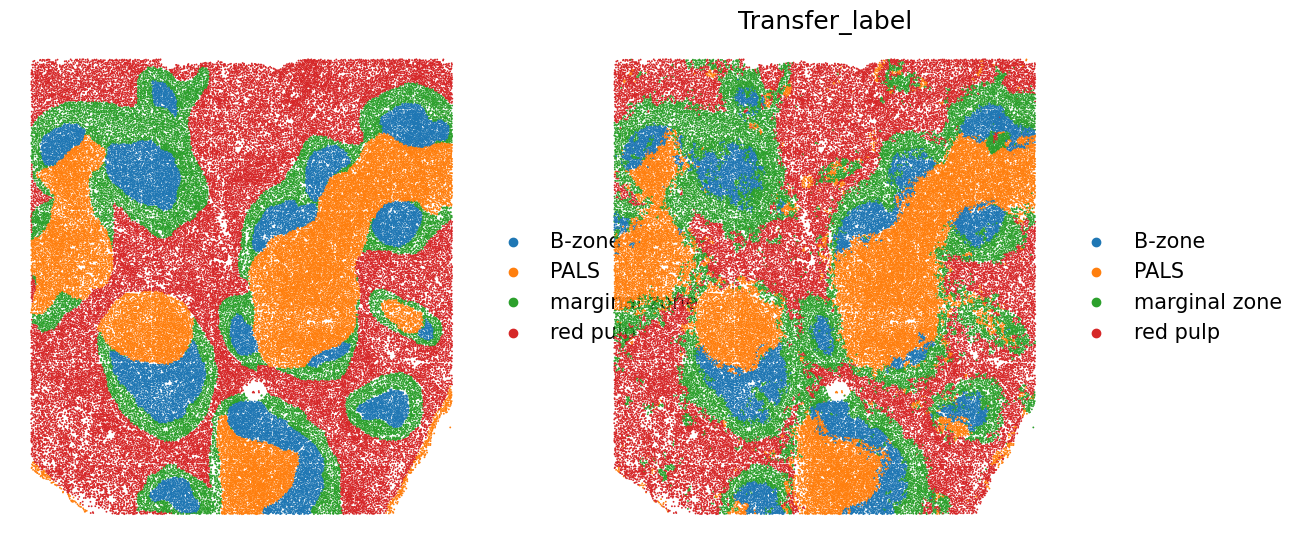

In [22]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,6.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata1, basis="spatial",s=7,color=['Compartment','Transfer_label'],colorbar_loc=None,title='',frameon=False)

In [23]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata1.obs['Compartment'])
cluster_labels = np.array(adata1.obs['Transfer_label'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.579377574436387
NMI: 0.5486168047263061
AMI: 0.5485984677220049
FMI: 0.6927263382225675
V-Measure: 0.5486168047263061
Homogeneity: 0.5510347382078853


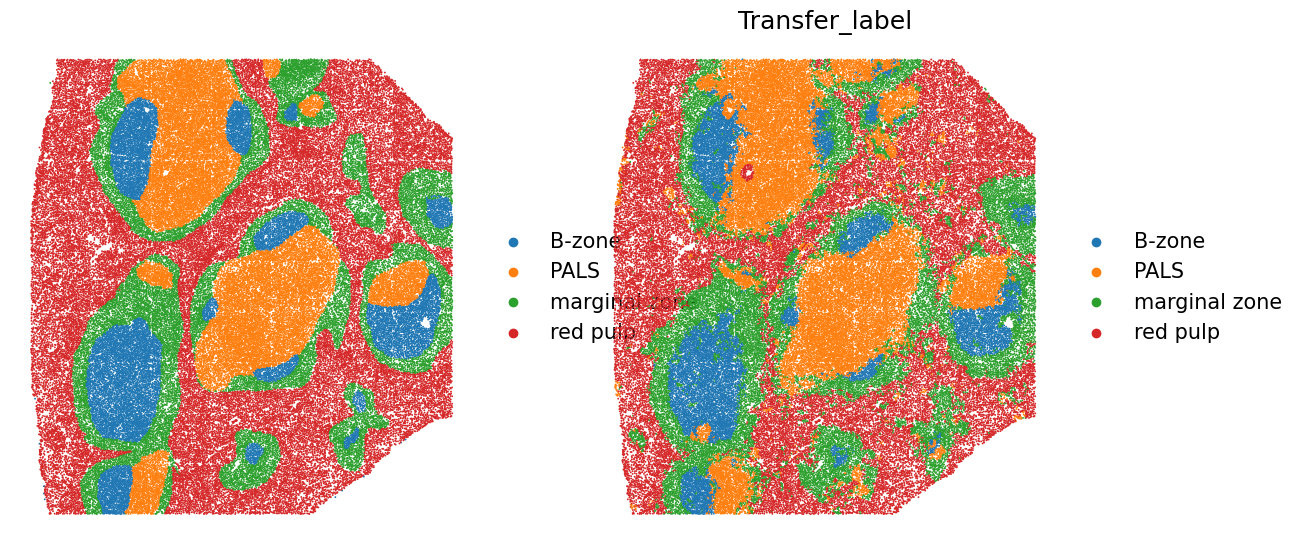

In [24]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,6.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata2, basis="spatial",s=7,color=['Compartment','Transfer_label'],colorbar_loc=None,title='',frameon=False)

In [25]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata2.obs['Compartment'])
cluster_labels = np.array(adata2.obs['Transfer_label'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.5570291019685638
NMI: 0.5313760842332116
AMI: 0.5313565592412505
FMI: 0.6810108304444059
V-Measure: 0.5313760842332116
Homogeneity: 0.5349825482317963


In [26]:
adata1.write_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/CODEX/setting3/Transfer1.h5ad',compression='gzip')
adata2.write_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/CODEX/setting3/Transfer2.h5ad',compression='gzip')